# Conductance-based Spiking Neural Network (conductance-SNN)

## Install required packages

In [1]:
import numpy as np
import scipy
import pylab as pl
import random
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.animation as animation
import copy
import math
from matplotlib import gridspec

## Functions used for simulation

### Initialize parameters

Initialize parameters

In [2]:
def initialize_params(N, dt, iterations, homogeneous_weights=True, gamma_hom=1, gamma_het=[1, 1]):
    """ Initialize parameters.
        
    Parameters
    ----------
    N : int
        number of neurons
    dt : int
        size between steps
    iterations : int
        length of the simulation
    beta : int
        cost
    homogeneous_weights : boolean, optional
        all neurons have same weights (True) or neurons have different weights (False)
    gamma : int, optional
        read-out weight of the neurons (only applies when homogeneous_weights=True)
        
    Returns
    ----------
    t : 1D-array
        timesteps
    x_est : 1D-array
        input estimate per timestep
    o : array
        spike trains, with value 0 if there is no spike and value 1/dt if there is a spike,
        size (N, iterations)  
    voltage : array
        voltages, size (N, iterations) 
    D : 1D-array
        read-out weights of the neurons
    T : 1D-array
        threshold of the neurons
    
    """

    t = np.arange(0, iterations) * dt                    # time
    x_est = np.zeros(iterations) * 0.1                   # input estimate
    o = np.zeros((N, iterations))                        # spike trains
    voltage = np.zeros((N, iterations))                  # voltages
    D = np.ones(N)                                       # ''output kernel''/weights
    if homogeneous_weights == True:
        D*= gamma_hom
    else:
        D = np.array(gamma_het)
    T = [(weight ** 2)/2 for weight in D]       # threshold

    return (t, x_est, o, voltage, D, T) 

### Time varying signal

Create time varying signal

In [3]:
def time_varying_signal(constant, c_upp=3, tau=1):
    """ Initialize time varying input signal with a plateau. 
    
    Parameters
    ----------
    constant : boolean
        indicates whether the signal should be constant (True) or not (False)
    c_upp : int, optional
        value of the plateau
    tau : int, optional
        time constant
    
    Returns
    ----------
    x : 1D-array
        input per timestep
    c : 1D-array
        sum of the input and input derivative per timestep
        
    """

    
    x = []
    
    if constant == True:
        # create constant signal
        x = np.ones(iterations) * c_upp
    else:
        # create time-varying signal
        x = c_upp
        x_t = np.ones(iterations) * x

        step = int(np.round(0.1 * iterations))
        x_t[0:2 * step] = 0
        x_t[iterations - 2 * step:iterations] = 0

        # smooth signal
        x = gaussian_filter1d(x_t, sigma=20)

    # compute c
    dxdt = np.diff(x)/dt
    c = x[:-1]/tau + dxdt
    
    return (x, c)

In [4]:
def time_varying_signal_sinusoidal(positive_input=True):
    """ Create time varying signal following a sinusoidal function. 
    
    Parameters
    ----------
    positive_only : boolean, optional
        Only positive input signal (True) or both negative and positive input signals (False)
    
    Returns
    ----------
    x : 1D-array
        input per timestep
    c : 1D-array
        sum of the input and input derivative per timestep
        
    """
    
    cycles = 3
    x = np.zeros(iterations)
    if positive_input == True:
        x = np.cos(np.pi + 2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations)) + 3
    else:
        x = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations))
    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt

    return x, c

### Run simulation

For the simulation, one uses the Euler method using the following derivative equations:

- $\dot{\hat{x}} = -\hat{x} + \sum^{N}_{k = 1} D_{k} s_{k}$ referred to as the $\textbf{online method}$.
- $(x + \hat{x} + \rho) \dot{V}_{i} = -\rho V_{i} + (\frac{x}{\tau} + \dot{x}) (1 - V_{i}) + \sum^{N}_{k = 1} (D_{ik} s_{k}) (-1 - V_{i}) - \beta s_{i}$ referred to as the $\textbf{offline method}$ where $\lambda = (x + \hat{x} + \rho)$.

In [26]:
def run(rho, tau, beta, E_e=1, E_i=-1, lambda_constant=False, var=0, permute_x_est=False):
    """ Run simulation of spike coding network. At each time step, the voltage and input estimate is computed
    using the Euler's method. The network follows a spike rule that if one of the voltage reaches threshold the
    network outputs a spike wherafter the voltages and input estimate are updated. 
    
    Parameters
    ----------
    rho : int
        network parameter
    tau : int, optional
        time constant
    beta : int, optional
        cost
    E_e : int, optional
        excitatory reversal potential
    E_i : int, optional
        inhibitory reversal potential
    lambda_constant : boolean, optional
        defines lambda as a constant (True) or as its true value (False)
    var : int, optional
        value of lambda (only applies when lambda_constant=True)
    permute_x_est : boolean, optional
        defines whether decoder should be perturbed (True) or not (False)
    
    """
    
    # initialize for readout permutation
    frac = np.zeros(iterations)
    x_est_cor = np.zeros(iterations)
    C_m = np.zeros(iterations)
    
    # initialize parameters
    lambda_val = 0
    r = np.zeros(N)
    
    # initialize exponential filter
    tau = 1.5
    y = [exponential_filter(i, tau) for i in np.arange(0, iterations) * dt]
    
    for t in range(1, iterations):
#         C_m[t] = np.dot(D.T, (x[t - 1] + x_est[t - 1])) + rho

        # compute lambda
        if lambda_constant == False:
            lambda_val = 1/(x[t - 1] + np.dot(D, r) + rho)
        else:
            lambda_val = 1/var
        
        # update voltages
        dVdt =  lambda_val * (-rho * (1/tau) * voltage[:, t - 1] + c[t - 1] * (E_e - voltage[:, t - 1]) + \
                              np.dot(D, o[:, t - 1]) * (E_i - voltage[:, t - 1]) - beta * o[:, t - 1])
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]
            
        # reset neuron when threshold is exceeded
        if len(above_threshold) > 0:

            # select random neuron who's voltage is above threshold
            spike_neuron = np.random.choice(above_threshold)

            # update spikes
            o[spike_neuron, t] = 1/dt

        # update estimate
        dxestdt = -x_est[t - 1] + np.dot(D.T, o[:, t])
        x_est[t] = x_est[t - 1] + dt * dxestdt
        
        if permute_x_est == True:
            x_est_cor[t] = x_est[t - 1] + rho * D[0] / (2 + 2 * T[0])
            x_est_cor[t] = x_est_cor[t] - D[0]/2

            x_est_cor[t] = x_est_cor[t] * (1 + T[0])/ (1 - T[0])

        # compute firing rate
        for i in range(N):
            r_temp = firing_rate(o[i, :], y)
            r[i] = r_temp[t] * dt
    
    return x_est_cor

## Functions used to visualize data

### Firing rate

Initialize exponential filter for the firing rate:

$r_{k}(t) = \int^{\infty}_{0} e^{-t'/\tau} s_{k}(t - t') dt'$

In [5]:
def exponential_filter(t, tau):
    """ Exponential filter. 
    
    Parameters
    ----------
    t : 1D-array
        timesteps
    tau : int
        rate of change
    
    Returns
    ----------
    filter : 1D-array
        exponential filter used for convolution
        
    """
    
    filter = np.exp(-t/tau)
    
    return filter

In [6]:
def firing_rate(spike_train, filt):
    """ Compute firing rate by the convolution of exponential filter and spike train. 
    
    Parameter
    ----------
    spike_train : 1D-array
        spike train
    filt : 1D-array
        filter for the convolution
    
    Returns
    ----------
    convolution : 1D-array
        convolution of the spike train with the filter
    
    """
    
    convolution = np.convolve(spike_train, filt)
    
    return convolution

Compute and plot firing rate per neuron

In [7]:
def visualize_firing_rate(tau):
    """ Compute and visualize firing rate of each neuron. 
    
    Parameter
    ----------
    tau : int
        rate of change
    
    """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1
    
    # initialize exponential filter
    y = [exponential_filter(i, tau) for i in t]

    # initialize plots
    plots = N
    pl.subplots(plots, 1, figsize=(32, 4*N))
    counter = 1

    # compute input estimate 
    for i in range(N):

        # compute firing rate
        firingrate = firing_rate(spike_trains[i, :], y)

        # plot firing rate
        pl.subplot(plots, 1, counter)
        pl.axis('off')
        counter = counter + 1
        pl.plot(t, firingrate[0: iterations], color=color[i, :], label='N%i'%(i+1), lw=12)
        pl.ylim(-0.5, max(firingrate) + 0.5)

### Membrane voltage

Compute voltage estimate one of two ways:

1) Computed voltage estimate using the derivative $\frac{dV_{i}}{dt} = \frac{1}{\lambda}(- \frac{1}{\tau} \rho V_{i} + (\frac{x}{\tau} + \dot{x}) (E_{E} - V_{i}) + \sum^{N}_{k = 1} (D_{ik} s_{k}) (-1 - V_{i}) - \beta r_{i})$ where $\lambda = (x + \hat{x} + \rho)$ referred to as the $\textbf{online method}$. 

2) Compute voltage estimate using a linear readout applied to the spike trains $V_{i} = \frac{D_{i}(x - \hat{x}) - \beta r_{i}}{D_{i}(x + \hat{x}) + \rho}$ referred to as the $\textbf{offline method}$.

In [8]:
def visualize_voltage(rho):
    """ Compute and visualize membrane voltage of each neuron. 
    
    Parameters
    ----------
    rho: int
        network parameter        
    
    Returns
    ----------
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1

    # initialize exponential filter
    tau = 1
    y = [exponential_filter(i, tau) for i in t]
    
    # compute input estimate (by method 2)
    x_est_offline = np.zeros(iterations)
    for j in range(iterations):
        for i in range(N):
            firingrate = firing_rate(spike_trains[i, :], y)
            x_est_offline[j] += D[i] * firingrate[j] 
    
    # compute voltage (by method 2)
    voltage_offline = np.zeros((N, iterations))
    for i in range(N):
        voltage_offline[i, :] = (D[i] * (x - x_est_offline)) / (D[i] * (x + x_est_offline + rho))

    # plot voltages
    counter = 1
    pl.subplots(N, 2, figsize=(14, 4))
    for i in range(N):
        
        # plot online voltages
        pl.subplot(N, 2, counter)
        if counter == 1:
            pl.title(r'Online $\frac{dV_{i}}{dt} = \frac{1}{\lambda}(- \frac{1}{\tau} \rho V_{i} + (\frac{x}{\tau} + \dot{x}) (E_{E} - V_{i}) + \sum^{N}_{k = 1} (D_{ik} s_{k}) (-1 - V_{i}) - \beta r_{i})$',  fontsize=20)    
        counter = counter + 1
        pl.plot(t, voltage[i, :], color=color[i, :], label='N%i'%(i+1))
        pl.plot(t, np.ones(iterations) * T[i], 'k') 
        
        
        # plot offline voltages
        pl.subplot(N, 2, counter)
        if counter == 2:
            pl.title(r'Offline $V_{i} = \frac{D_{i}(x - \hat{x}) - \beta r_{i}}{D_{i}(x + \hat{x}) + \rho}$', fontsize=20)
        counter = counter + 1
        pl.plot(t, voltage_offline[i, :], color=color[i, :], label='N%i'%(i+1))
        pl.plot(t, np.ones(iterations) * T[i], 'k') 
        
    return voltage_offline

In [9]:
def plot_voltage_diff(voltage_online, voltage_offline):
    """ Plot difference between online and offline voltage.
    
    Parameters
    ----------
    voltage_online : array
        voltages computed using the online method, size (N, iterations)
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    pl.rc('text', usetex=True)
    pl.plot(t, voltage_online - voltage_offline, 'k')
    pl.ylabel(r'$V_{online} - V_{offline}$')
    pl.xlabel('time')

### Inpute estimate

Compute input estimate one of two ways:

1) Computed input estimate using the derivative $\dot{\hat{x}} = -\hat{x} + \sum^{N}_{k = 1} D_{k} s_{k}$

2) Compute input estimate using a linear readout applied to the spike trains $\hat{x} = \sum^{N}_{k = 1} D_{k} r_{k}$

In [10]:
def visualize_estimate():
    """ Plot estimate of the input signal. 
    
    Returns
    ----------
    x_est_offline : array
        input estimate computed using the offline method, size (N, iterations)
        
    """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1

    # initialize exponential filter
    tau = 1
    y = [exponential_filter(i, tau) for i in t]

    # compute input estimate (by method 2)
    x_est_offline = np.zeros(iterations)
    for j in range(iterations):
        for i in range(N):
            firingrate = firing_rate(spike_trains[i, :], y)
            x_est_offline[j] += D[i] * firingrate[j] 

    pl.subplots(1, 2, figsize=(14, 2))
    
    # plot online estimate
    pl.subplot(1, 2, 1)
    pl.title('Online $\dot{\hat{x}} = -\hat{x} + \sum^{N}_{k = 1} D_{k} s_{k}$', fontsize='20')
    pl.plot(t, x_est, color='gray', label=r'$\hat{x}$')
    pl.plot(t, x, 'k', label=r'$x$')

    # plot offline estimate
    pl.subplot(1, 2, 2)
    pl.title('Offline $\hat{x} = \sum^{N}_{k = 1} D_{k} r_{k}$',  fontsize='20')
    pl.plot(t, x_est_offline, color='gray', label=r'$\hat{x}$')
    pl.plot(t, x, 'k', label=r'$x$')
    
    return x_est_offline

In [11]:
def plot_estimate_diff(x_est_online, x_est_offline):
    """ Plot difference between online and offline input estimate.
    
    Parameters
    ----------
    x_est_online : 1D-array
        input estimate computed using the online method, size (iterations)
    x_est_offline : 1D-array
        input estimate computed using the offline method, size (iterations)
    
    """
    
    pl.rc('text', usetex=True)
    pl.plot(t, x_est_online - x_est_offline, 'k')
    pl.ylabel(r'$\hat{x}_{online} - \hat{x}_{offline}$')
    pl.xlabel('time')

### Membrame capacitance

In [12]:
def membrane_capacitance(cap):
    """ Plots the input + readout as well as the membrane capacitance over time.
    
    Parameters:
    ----------
    cap: 1D-array
        the membrane capacitance over time

    """
    
    # initiate plot
    pl.subplots(2, 1, figsize=(16, 5))
    w= 5

    # plot input and readout
    pl.axis('off')
    pl.subplot(2, 1, 1)
    pl.axis('off')
    pl.plot(t, x, 'k', lw=w)
    pl.plot(t, x_est, 'gray', lw=w)
    
    # plot membrame capacitance
    pl.subplot(2, 1, 2)
    pl.axis('off')
    pl.plot(t, cap, 'k', lw=w)
    pl.ylabel('Membrane capacitance')

### Visualize results simulation

Functions used to visualize results

In [13]:
def zero_to_nan(spike_trains, val=0):
    """Replace every 0 with 'nan' and return a copy.
    
    Parameters
    ----------
    spike_trains : array
        spike trains of the different neurons
    val : int, opt
        value that is replaced by NaN
    
    Returns
    ----------
    o_Nan : array
        array where every 0 is replaced by NaN, size (spike_trains.shape)
        
    """
    
    o_Nan = [float('nan') if x==val else x for x in spike_trains]
    
    return o_Nan

In [14]:
def visualize(color, plot_voltage=True, plot_c=False, plot_E=False):
    """ Visualize results of the simulation of the spike coding network. Return one plot with the input and input estimate,
    one plot with the spike trains, and N plots for the voltages.
    
    Parameters
    ----------
    color : array
        RGB values for every neuron, size = (N, 3)
    plot_voltages : boolean, optional
        voltages are plotted (True) or not (False)
    plot_c : boolean, optional
        sum of input plus input derivative is plotted (True) or not (False)
    plot_E : boolean, optional
        plot the reversal potentials for excitation and inhibition (True) or not (False)
    
    """ 
    
    # initialize plots
    if plot_voltage == True:
        plots = 2 + N
    else:
        plots = 2
    fig = pl.subplots(plots, 1, figsize=(16, 8))
    pl.subplots_adjust(hspace=0.7)
    pl.rc('text', usetex=True)
    pl.tight_layout()
    w = 5 

    # plot input and input estimate
    pl.subplot(plots, 1, 1)
    pl.xlim(0, iterations * dt)
    pl.xticks([])
    pl.yticks(fontsize=15)
    pl.plot(t, x, label=r'$x$', color='black', lw=w)
    if permute_x_est == True:
        pl.plot(t, x_est_cor, label=r'$\hat{x}$', color='gray', lw=w)
    else:
        pl.plot(t, x_est, label=r'$\hat{x}$', color='gray', lw=w)
    pl.axis('off')
    if plot_c == True:
        pl.plot(t[:-1], c, '--k', label=r'$x + \dot{x}$', alpha=0.2)
    
    # plot spike trains
    pl.subplot(plots, 1, 2)
    pl.axis('off')
    pl.xticks([])
    pl.yticks(fontsize=15)
    pl.xlim(0, iterations * dt)
    spike_times = []
    for i in range(N):
        idx = np.where(o[i, :] == 1/dt)
        temp = [t[i] for i in idx[0]]
        spike_times.append(temp)
    pl.eventplot(spike_times, linelengths=[0.5], color=color, lw=w)
    counter = 3
    
    # plot voltage over time
    if plot_voltage == True:
        for i in range(N):
            pl.subplot(plots, 1, counter)
            counter += 1
            pl.axis('off')
            pl.xlim(0, iterations * dt)
            pl.yticks(fontsize=15)
            pl.plot(t, voltage[i, :], color=color[i], label='N%i'%(i+1), alpha=0.8, lw=w)
            pl.plot(t, np.ones(iterations) * T[i], color='gray', alpha=0.4, lw=w)
            if plot_E == True:
                pl.plot(t, np.ones(iterations) * E_e, '--r', alpha=0.5, label='Reversal potential E', lw=w)
                pl.plot(t, np.ones(iterations) * E_i, '--b', alpha=0.5, label='Reversal potential I', lw=w)
        pl.xticks(fontsize=15)

In [15]:
def visualize_single_neuron():
    """ Visualizes results for a simulation with one neuron. """
    
    # initialize plot
    plots = 5
    fig = pl.figure(figsize=(16, 10))
    w = 4

    ax1 = pl.subplot2grid((plots, 1), (0, 0), rowspan=2)
    pl.yticks(fontsize=15)
    pl.axis('off')
    pl.xticks([])
    pl.plot(t, x, label=r'$x$', color='black', lw=w)
    if permute_x_est == True:
        pl.plot(t, x_est_cor, label=r'$\hat{x}$', color='gray', lw=w)
    else:
        pl.plot(t, x_est, label=r'$\hat{x}$', color='gray', lw=w)
    if plot_c == True:
        pl.plot(t[:-1], c, '--k', label=r'$x + \dot{x}$', alpha=0.2, lw=w)
    pl.xlim(0, iterations * dt)
#    pl.ylim(-0.1, 7)

    ax2 = pl.subplot2grid((plots, 1), (2, 0))
    pl.axis('off')
    pl.xticks([])
    pl.yticks(fontsize=15)
    pl.xlim(0, iterations * dt)
    spike_times = []
    for i in range(N):
        idx = np.where(o[i, :] == 1/dt)
        temp = [t[i] for i in idx[0]]
        spike_times.append(temp)
    pl.eventplot(spike_times, color='k', linelengths=[1], lw=w)
    pl.xlim(0, iterations * dt)

    # plot voltage over time
    if plot_voltage == True:
        ax3 = pl.subplot2grid((plots, 1), (3, 0), rowspan=2)
        pl.ylim(-2, 0.6)
        pl.axis('off')
        pl.xlim(0, iterations * dt)
        pl.xticks(fontsize=15)
        pl.yticks(fontsize=15)
        pl.ylim(-1, 0.6)
        for i in range(N):
            pl.plot(t, voltage[i, :], color='k', label='N%i'%(i+1), alpha=0.8, lw=w)
            pl.plot(t, np.ones(iterations) * T[i], color='gray', alpha=0.4, lw=w)
            if plot_E == True:
                pl.plot(t, np.ones(iterations) * E_e, '--r', alpha=0.5, label='Reversal potential E', lw=w)
                pl.plot(t, np.ones(iterations) * E_i, '--b', alpha=0.5, label='Reversal potential I', lw=w)

## Run simulation

### $\textit{N}$-neurons

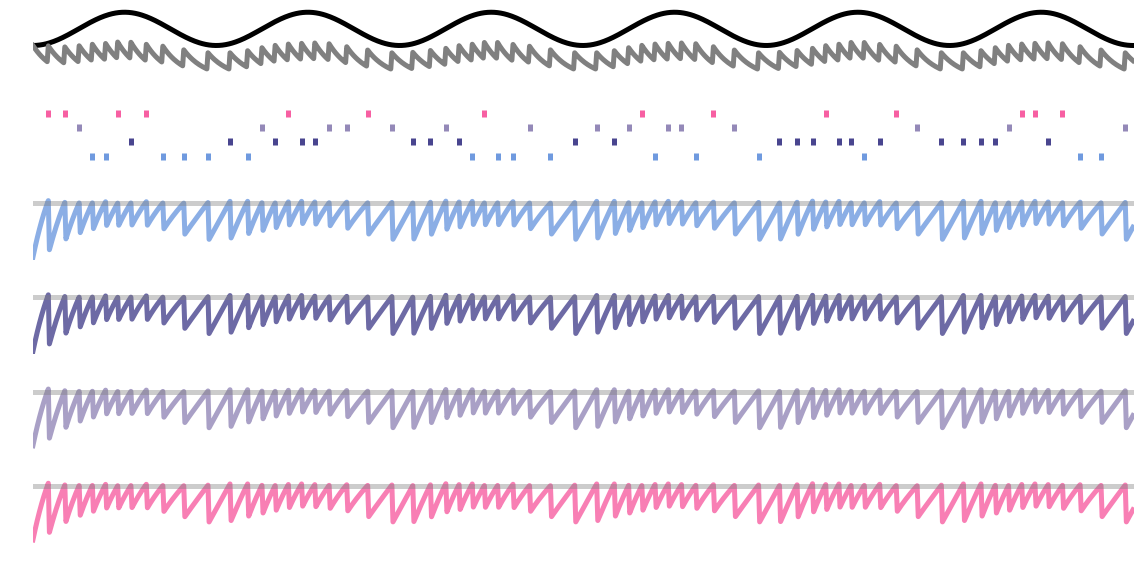

In [27]:
N = 4                                                   # number of neurons
dt = 0.05                                               # time step
iterations = 1000                                       # length of simulation
homogeneous_weights = True                              # homogeneous weights or different weights for each neuron
gamma_hom = 1                                           # readout weight if homogeneous
positive_input = True                                   # allow negative or only positive input signal
constant= False                                         # create constant or time-variant input signal
sinusoidal = True                                       # create sinusoidal wafevorm as input signal
c_upp = 5                                               # value signal input
rho = 0.1
color = np.random.randint(0, 255, size=(N, 3))/255      # assign color to each neuron
tau = 1                                                 # time constant
beta = 0.0                                              # cost
E_e = 1                                                 # excitatory reversal potential
E_i = -1                                                # inhibitory reversal potential
lambda_constant = False                                 # indicates use of lambda                
var = 1
permute_x_est = False                                   # permute readout
color = np.random.randint(0, 255, size=(N, 3))/255      # return color for each neuron
plot_c = False                                          # plot the input + input der (=c) or only input signal
plot_voltage= True                                      # plot the voltages
plot_E = False                                          # plot reversal potentials

# run simulation
if homogeneous_weights == True:
    t, x_est, o, voltage, D, T = initialize_params(N=N, dt=dt, iterations=iterations, homogeneous_weights=homogeneous_weights, gamma_hom=gamma_hom)
else:
    t, x_est, o, voltage, D, T = initialize_params(N=N, dt=dt, iterations=iterations, homogeneous_weights=homogeneous_weights, gamma_het=gamma_het)
# x_est[0] = 2
if sinusoidal == True:
    x,c     = time_varying_signal_sinusoidal(positive_input=positive_input)
else:
    x,c     = time_varying_signal(constant=constant, c_upp=c_upp, tau=tau)  
x_est[0] = 2
x_est_cor = run(rho=rho, tau=tau, beta=beta, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, var=var, permute_x_est=permute_x_est)
if N == 1:
    visualize_single_neuron()
else:
    visualize(color=color, plot_voltage=plot_voltage, plot_c=plot_c, plot_E=plot_E)

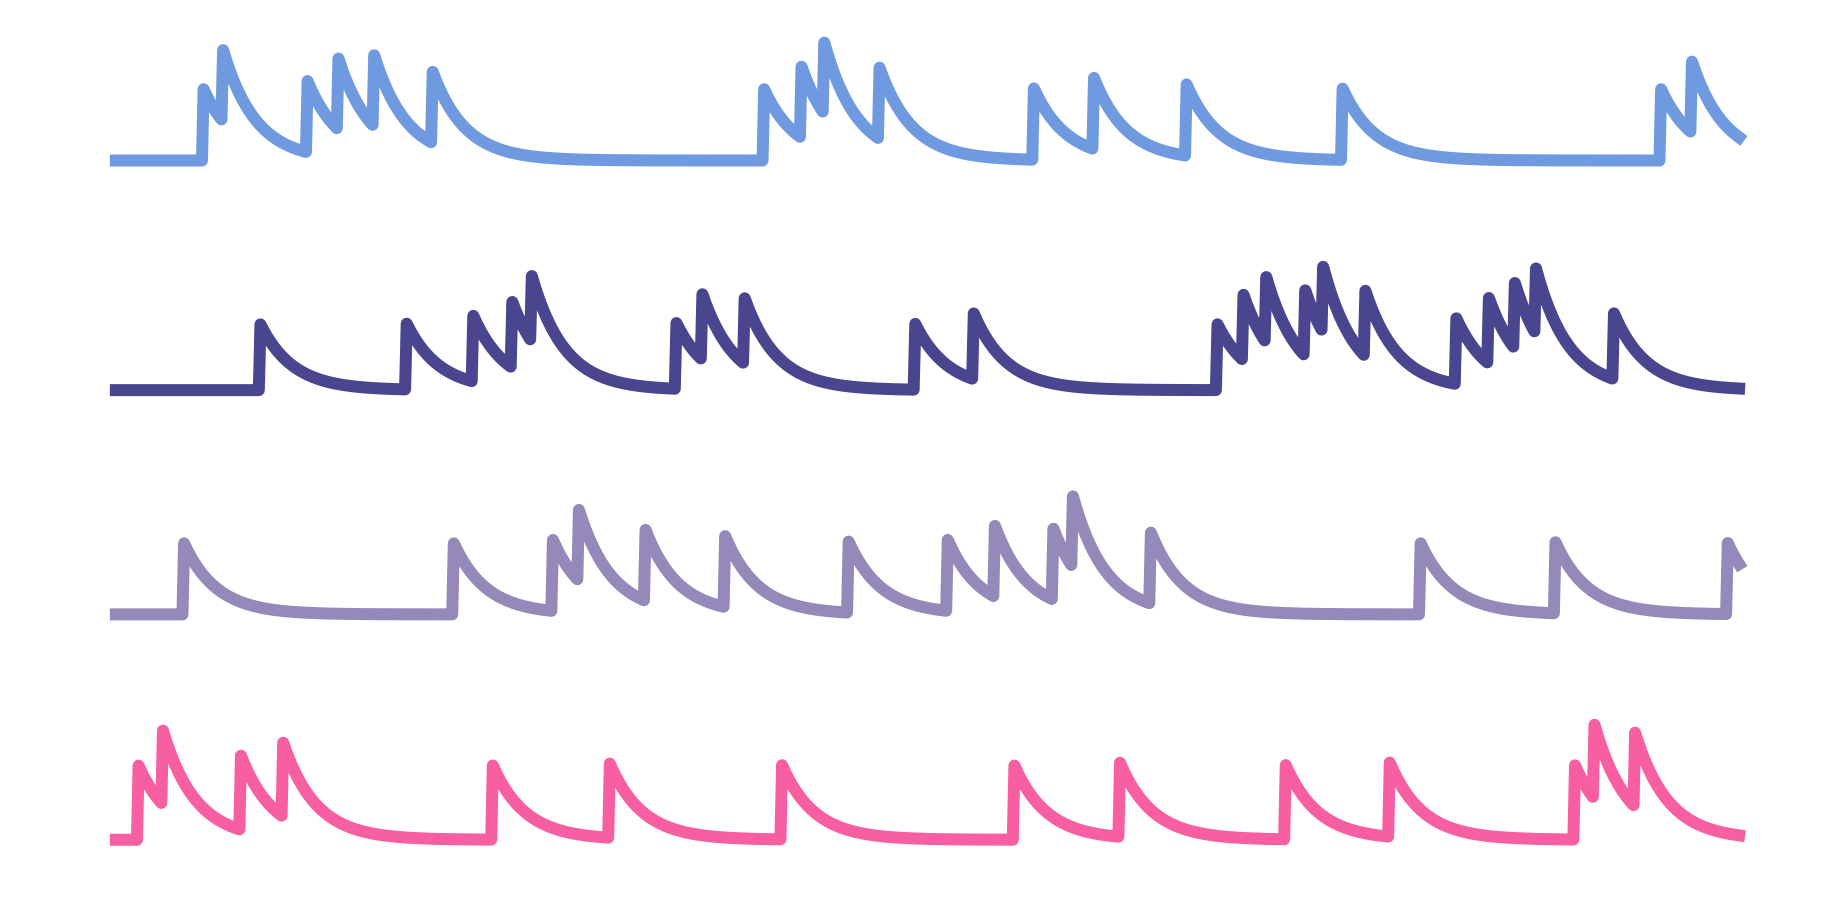

In [28]:
visualize_firing_rate(tau)

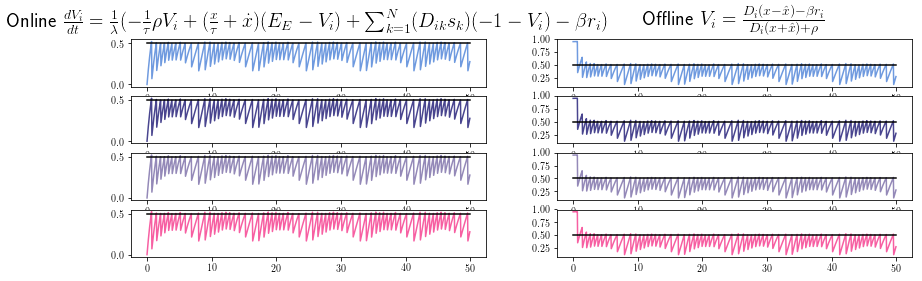

In [29]:
voltage_offline = visualize_voltage(rho)

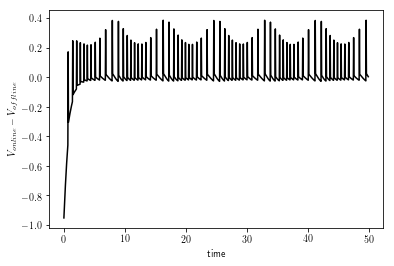

In [30]:
neuron = 1
if neuron < 1 or neuron > N:
    print("Enter valid neuron")
else:
    plot_voltage_diff(voltage[neuron - 1, :], voltage_offline[neuron - 1, :])

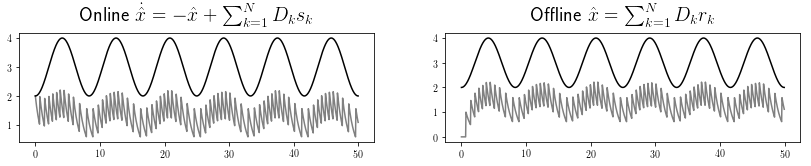

In [31]:
x_est_offline = visualize_estimate()

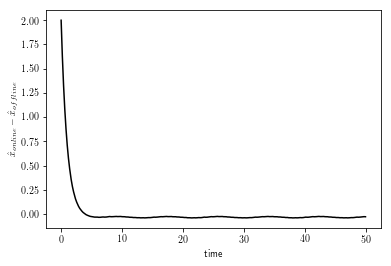

In [32]:
plot_estimate_diff(x_est, x_est_offline)

## Set network parameters

In [11]:
def set_network(N = 1,
                dt = 0.05,
                iterations = 1500,
                homogeneous_weights = True,
                gamma = 1, 

                sinusoidal = False,
                positive_input = True,
                constant = True,
                c_upp = 0.6, 

                rho = 0.1,
                tau = 1, 
                beta = 0,
                E_e = 1, 
                E_i = -1,
                lambda_constant = False,                 
                var = 1,
                permute_x_est = False,

                plot_voltage = True,
                plot_c = True):
    
    """ Resets all the parameters to its default values. 
    
    Parameters
    ----------
    N : int
        number of neurons
    dt : int
        time step
    iterations : int
        length of simulation
    homogeneous_weights : boolean
        indicates whether weights are equal (True) or not (False)
    gamma : int
        decoding-weight (only applies if homogeneous_weights=True)
    sinusoidal  boolean
        indicates whether input signal is sinusoidal (True) or not (False)
    positive_input : boolean
        indicates whether input signal is positive (True) or not (False)
    constant : boolean
        indicates whether input signal behaves as a constant (True) or time-varying signal (False)
    c_upp : int
        maximal value of the input signal
    rho : int
        value to avoid zero-division when input and input estimate are zero
    tau : int
        time-scale of filtering
    beta : int
        cost
    E_e : int
        excitatory reversal potential
    E_i : int
        inhibitory reversal potential
    lambda_constant : boolean
        indicates whether lambda is constant (True) or varies (False)
    var : int
        value of lambda (only applies if lambda_constant=True)
    permute_x_est : boolean
        indicates whether input estimate is permuted at every time step (True) or not (False)
    plot_voltage : boolean
        indicates whether voltages should be plotted (True) or not (False)
    plot_c : boolean
        indicates whether the sum of the input signal and its derivative should 
        be plotted (True) or not (False)
    
    """
    
    N = N
    dt = dt
    iterations = iterations
    homogeneous_weights = homogeneous_weights
    gamma = gamma                                                

    sinusoidal = sinusoidal
    positive_input = positive_input
    constant = constant
    c_upp = c_upp

    rho = rho
    tau = tau
    beta = beta 
    E_e = E_e   
    E_i = E_i
    lambda_constant = lambda_constant  
    var = var
    permute_x_est = permute_x_est

    color = np.random.randint(0, 255, size=(N, 3))/255
    plot_voltage = plot_voltage
    plot_c = plot_c
    
    return N, dt, iterations, homogeneous_weights, gamma, sinusoidal, positive_input, \
    constant, c_upp, rho, tau, beta, E_e, E_i, lambda_constant, var, permute_x_est, \
    color, plot_voltage, plot_c

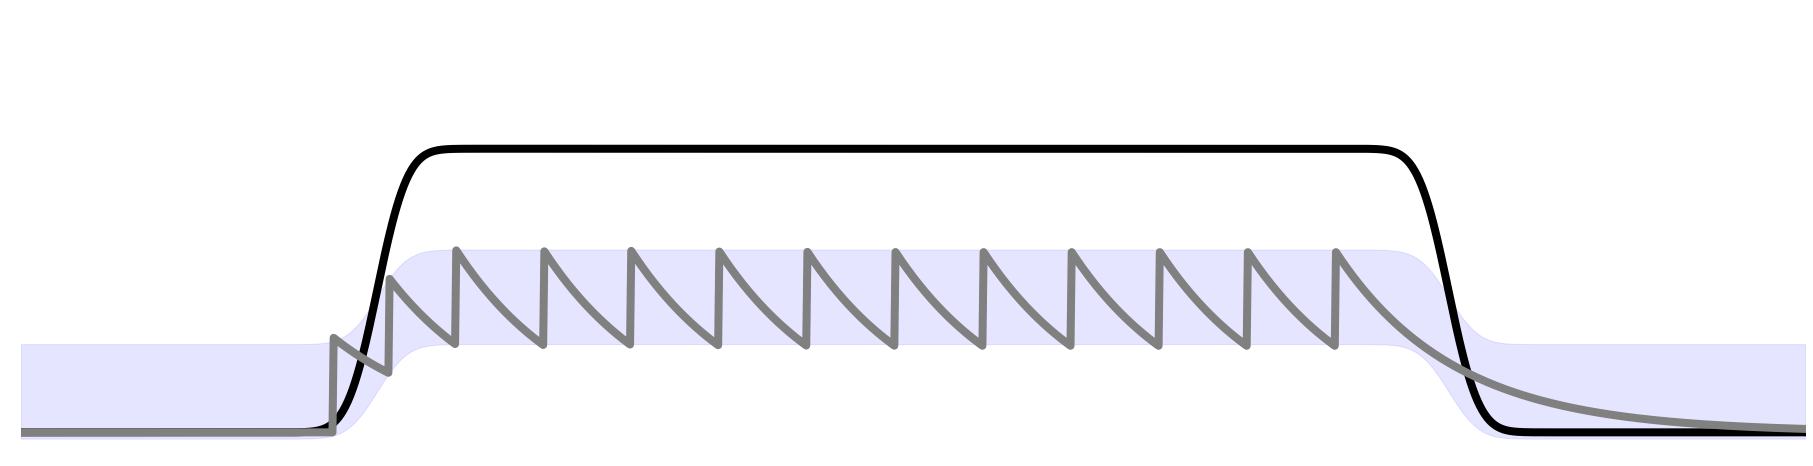

In [97]:
def LM_plot_input(input, bounding_box=True):
    """ Plots input and bounding box.
    
    Parameters
    ----------
    input : 1D-array
        signal inputs
    bounding_box : boolean, optional
        plot bounding box (True) or not (False)
    
    """
    
    # initialize input
    inputs = np.zeros((len(input), iterations))
    inputsdt = np.zeros((len(input), iterations))
    w = 8

    # creates signal
    for i in range(len(input)):
        inputs[i, :], inputsdt = time_varying_signal(constant=False, c_upp = input[i])

    # computes threshold
    thresh_low = np.zeros((len(I), iterations))
    for j in range(len(I)):
        for i in range(iterations):
            thresh_low[j, i] = inputs[j, i] * (1 - T[0]) / (1 + T[0]) - rho * D[0] / (1 + T[0])  

    # initializes plots
    counter = 1

    #fig, ax = pl.subplots()
    for i in range(len(I)):
        fig = pl.figure(figsize=(32,8))
        pl.axis('off')

        counter += 1
        pl.plot(t, inputs[i, :], 'k', lw=w)
        pl.plot(t, x_est, 'gray', lw=w)
        pl.xlim([0, iterations * dt])
        pl.ylim(-0.1, 4.5)
#        pl.plot(t, thresh_low[i, :], color=np.array([0, 0, 160])/255, linestyle='--', lw=w)
        if bounding_box == True:
            pl.fill_between(t, thresh_low[i, :], thresh_low[i, :] + D[0], color='blue', alpha=0.1)
            #pl.plot(t, thresh_low[i, :], color=np.array([255, 204, 0])/255, linestyle='--', lw=w)

I = [3]
LM_plot_input(I, bounding_box=True)

## Plot for input and input estimate (toy examples for N = 1)

## plot voltages and spikes in one plot

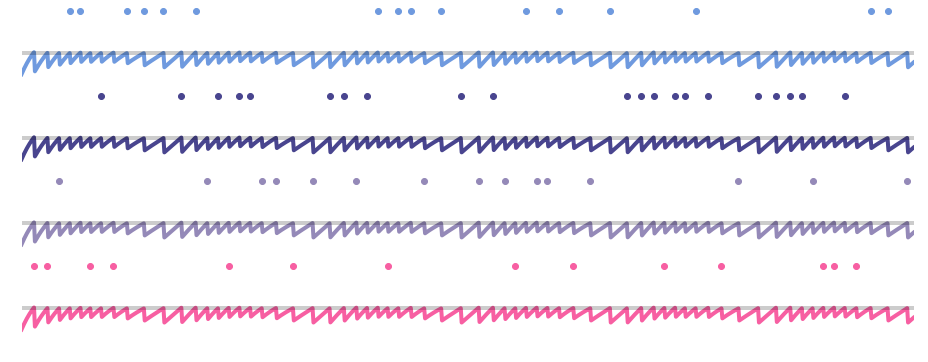

In [33]:
def LM_plot_voltage():
    """ Plot voltages, spike trains and thresholds per neuron. """
    
    fig= pl.figure(figsize=(16,6))
    counter = 1
    
    for i in range(N):
        
        # initialize plots
        pl.subplot(N, 1, counter)
        pl.axis('off')
        counter = counter + 1
        pl.xlim([0, iterations * dt])
        pl.xticks()
        pl.tick_params(labelsize=15)
        
        # plot data
        w=4
        pl.plot(t, voltage[i - 1], color=color[i, :], lw=w, label='N%i'%i)
        pl.plot(t, np.ones(iterations) * T[i], 'k', lw=w,  alpha=0.2)
        values = zero_to_nan(o[i, :] * dt * T[i] + 1, 1) 
        pl.scatter(t, values, color=color[i, :], label='Neuron %i' %i)
    
LM_plot_voltage()

## Parameter manipulation

In [922]:
def visualize_multi(counter, num, color, plot_voltage=True, plot_c=False, lambda_constant = False, var=0):
    """ Visualize results of the simulation of the spike coding network for more than one
    simulation to compare the behaviour of the voltage and input estimate. Returns for every 
    simulation one plot with the input and input estimate, one plot with the spike trains, 
    and N plots for the voltages.
    
    Parameters
    ----------
    counter: int
        number of simulations
    num: int
        simulation number
    color: vector
        RGB values for plotting the different neurons
    plot_voltages: boolean, optional
        voltages are plotted (True) or not (False)
    plot_c: boolean, optional
        sum of input plus input derivative is plotted (True) or not (False)
    
    """ 
    
    # plot input and input estimate
    pl.subplot(plots, num, counter)
    counter += 2
    pl.plot(t, x, label=r'$x$', color='black')
    pl.plot(t, x_est, label=r'$\hat{x}$', color='gray')
    if plot_c == True:
        pl.plot(t[:-1], c, '--k', label=r'$x + \dot{x}$', alpha=0.2)
    pl.xlim(0, iterations * dt)
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # plot spike trains
    pl.subplot(plots, num, counter)
    counter += 2
    pl.xlim(0, iterations * dt)
    spike_times = []
    for i in range(N):
        idx = np.where(o[i, :] == 1/dt)
        temp = [t[i] for i in idx[0]]
        spike_times.append(temp)
    pl.eventplot(spike_times, linelengths=[0.8], color=color)
    pl.xlim(0, iterations * dt)

    # plot voltages
    if plot_voltage == True:
        for i in range(N):
            pl.subplot(plots, num, counter)
            counter += 2

            pl.plot(t, voltage[i - 1, :], color=color[i, :], label='N%i'%i)
            pl.plot(t, np.ones(iterations) * T[i], color='gray', label='threshold')
            pl.plot(t, np.ones(iterations) * E_e, '--r', alpha=0.5, label='Reversal potential E')
            pl.plot(t, np.ones(iterations) * E_i, '--b', alpha=0.5, label='Reversal potential I')

            pl.xlim(0, iterations * dt)
            pl.ylabel('Voltage')
            pl.title('Neuron %i' %i)
            pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Varying feedforward input

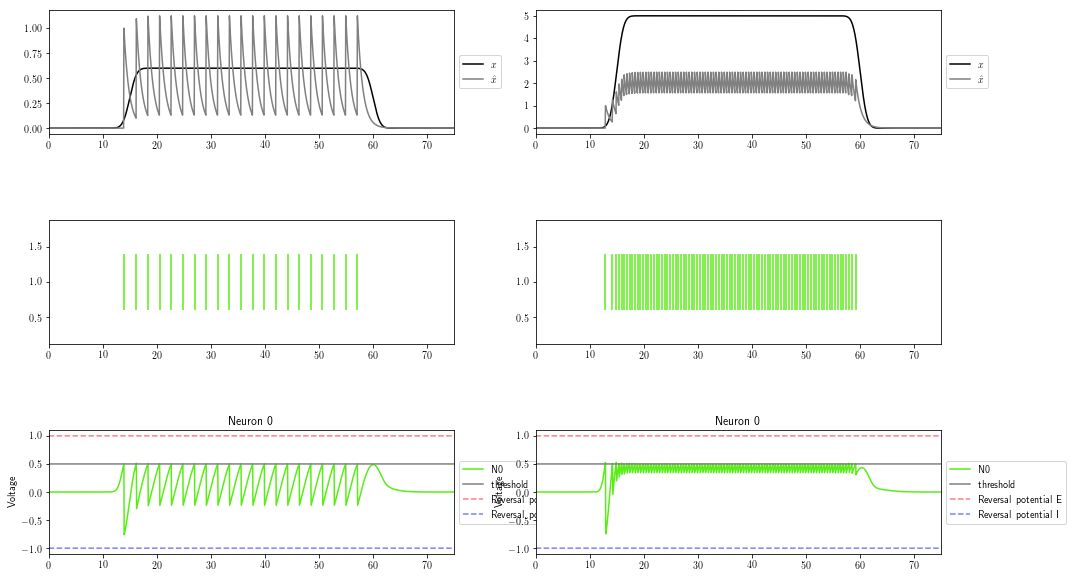

In [924]:
# initiate plots
plots = N + 2
num = 2
pl.subplots(plots, num, figsize=(16, 10))
pl.subplots_adjust(hspace=0.7)
pl.rc('text', usetex=True)
color = np.random.randint(0, 255, size=(N, 3))/255
counter = 1

# varying parameter feedforward input
input = [0.6, 5]

for i in range(2):
    N = 1
    dt = 0.05
    iterations = 1500
    homogeneous_weights = True
    gamma_hom = 1
    sinusoidal = False
    positive_input = True
    constant = False
    c_upp = input[i]

    rho = 0.1
    tau = 1
    beta = 0.0
    E_e = 1
    E_i = -1
    lambda_constant = False                 
    var = 1
    permute_x_est = False

    plot_voltage = True
    plot_c = False
    plot_E = True

    # run sim
    t, x_est, o, voltage, D, T = initialize_params(N=N, 
                                                   dt=dt, 
                                                   iterations=iterations, 
                                                   homogeneous_weights=homogeneous_weights, 
                                                   gamma_hom=gamma_hom)

    if sinusoidal == True:
        x,c     = time_varying_signal_sinusoidal(positive_input=positive_input)
    else:
        x,c     = time_varying_signal(constant=constant, 
                                      c_upp=c_upp,
                                      tau=tau)  

    cap, x_est_cor = run(rho=rho, 
                         tau=tau, 
                         beta=beta, 
                         E_e=E_e, 
                         E_i=E_i, 
                         lambda_constant=lambda_constant, 
                         var=var, 
                         permute_x_est=permute_x_est)


    visualize_multi(counter, num, color, plot_voltage=True, plot_c=False, lambda_constant=True, var=var)
    counter += 1

## Varying $\lambda$

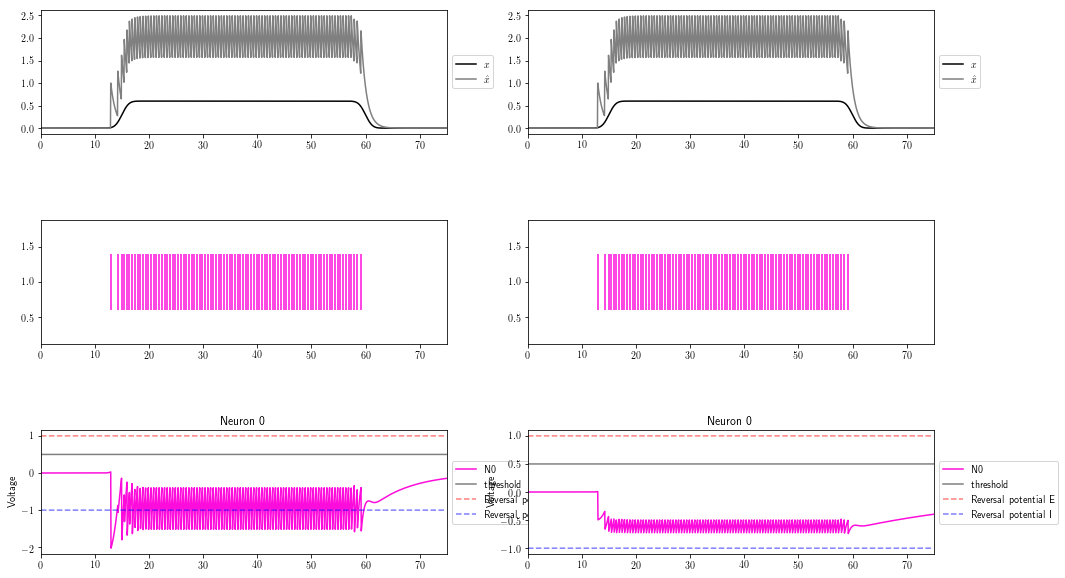

In [925]:
# initiate plots
plots = N + 2
num = 2
pl.subplots(plots, num, figsize=(16, 10))
pl.subplots_adjust(hspace=0.7)
pl.rc('text', usetex=True)
color = np.random.randint(0, 255, size=(N, 3))/255
counter = 1

# varying parameter lambda
lambda_constant = True  
input = [0.5, 2]


for i in range(2):
    N = 1
    dt = 0.05
    iterations = 1500
    homogeneous_weights = True
    gamma_hom = 1
    sinusoidal = False
    positive_input = True
    constant = False
    c_upp = 0.6

    rho = 0.1
    tau = 1
    beta = 0.0
    E_e = 1
    E_i = -1
               
    var = input[i]
    permute_x_est = False

    plot_voltage = True
    plot_c = False
    plot_E = True

    if sinusoidal == True:
        x,c     = time_varying_signal_sinusoidal(positive_input=positive_input)
    else:
        x,c     = time_varying_signal(constant=constant, 
                                      c_upp=c_upp,
                                      tau=tau)  

    cap, x_est_cor = run(rho=rho, 
                         tau=tau, 
                         beta=beta, 
                         E_e=E_e, 
                         E_i=E_i, 
                         lambda_constant=lambda_constant, 
                         var=var, 
                         permute_x_est=permute_x_est)

    run(rho=rho, 
        tau=tau, 
        beta=beta, 
        E_e=E_e, 
        E_i=E_i, 
        lambda_constant=lambda_constant, 
        var=var,
        permute_x_est=permute_x_est)

    visualize_multi(counter, num, color, plot_voltage=True, plot_c=False, lambda_constant=True, var=var)
    counter += 1

## Varying excitatory reversal potential with respect to threshold

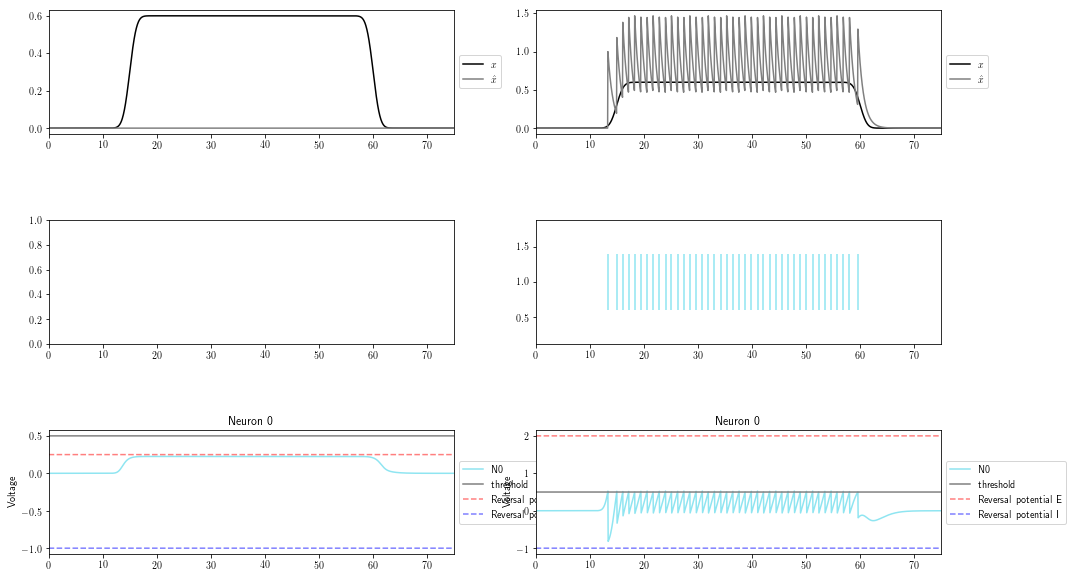

In [926]:
# initiate plots
plots = N + 2
num = 2
pl.subplots(plots, num, figsize=(16, 10))
pl.subplots_adjust(hspace=0.7)
pl.rc('text', usetex=True)
color = np.random.randint(0, 255, size=(N, 3))/255
counter = 1

# varying parameter excitatory reversal potential
input = [0.25, 2]

for i in range(2):
    N = 1
    dt = 0.05
    iterations = 1500
    homogeneous_weights = True
    gamma_hom = 1
    sinusoidal = False
    positive_input = True
    constant = False
    c_upp = 0.6

    rho = 0.1
    tau = 1
    beta = 0.0
    E_e = input[i]
    E_i = -1
    lambda_constant = False                 
    var = 1
    permute_x_est = False

    plot_voltage = True
    plot_c = False
    plot_E = True

    # run sim
    t, x_est, o, voltage, D, T = initialize_params(N=N, 
                                                   dt=dt, 
                                                   iterations=iterations, 
                                                   homogeneous_weights=homogeneous_weights, 
                                                   gamma_hom=gamma_hom)

    if sinusoidal == True:
        x,c     = time_varying_signal_sinusoidal(positive_input=positive_input)
    else:
        x,c     = time_varying_signal(constant=constant, 
                                      c_upp=c_upp,
                                      tau=tau)  

    cap, x_est_cor = run(rho=rho, 
                         tau=tau, 
                         beta=beta, 
                         E_e=E_e, 
                         E_i=E_i, 
                         lambda_constant=lambda_constant, 
                         var=var, 
                         permute_x_est=permute_x_est)

    visualize_multi(counter, num, color, plot_voltage=True, plot_c=False, lambda_constant=True, var=var)
    counter += 1

## Varying inhibitory reversal potential

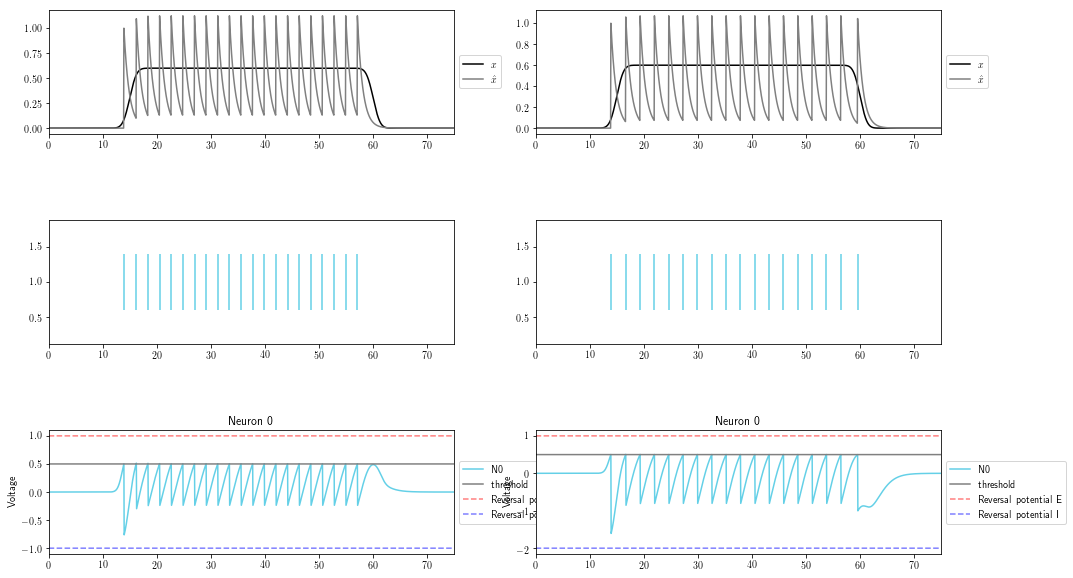

In [927]:
# initiate plots
plots = N + 2
num = 2
pl.subplots(plots, num, figsize=(16, 10))
pl.subplots_adjust(hspace=0.7)
pl.rc('text', usetex=True)
color = np.random.randint(0, 255, size=(N, 3))/255
counter = 1

# varying parameter inhibitory reversal potential
input = [-1, -2]

for i in range(2):
    N = 1
    dt = 0.05
    iterations = 1500
    homogeneous_weights = True
    gamma_hom = 1
    sinusoidal = False
    positive_input = True
    constant = False
    c_upp = 0.6

    rho = 0.1
    tau = 1
    beta = 0.0
    E_e = 1
    E_i = input[i]
    lambda_constant = False                 
    var = 1
    permute_x_est = False

    plot_voltage = True
    plot_c = False
    plot_E = True

    # run sim
    t, x_est, o, voltage, D, T = initialize_params(N=N, 
                                                   dt=dt, 
                                                   iterations=iterations, 
                                                   homogeneous_weights=homogeneous_weights, 
                                                   gamma_hom=gamma_hom)

    if sinusoidal == True:
        x,c     = time_varying_signal_sinusoidal(positive_input=positive_input)
    else:
        x,c     = time_varying_signal(constant=constant, 
                                      c_upp=c_upp,
                                      tau=tau)  

    cap, x_est_cor = run(rho=rho, 
                         tau=tau, 
                         beta=beta, 
                         E_e=E_e, 
                         E_i=E_i, 
                         lambda_constant=lambda_constant, 
                         var=var, 
                         permute_x_est=permute_x_est)

    visualize_multi(counter, num, color, plot_voltage=True, plot_c=False, lambda_constant=True, var=var)
    counter += 1